# Cybersecurity Intrusion Detection

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score,accuracy_score
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

In [ ]:
df = pd.read_csv('cybersecurity_intrusion_data.csv')

# Cybersecurity Intrusion Detection

## 1. Descriptive Analysis

In [ ]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (9537, 11)


The dataset contains 9537 rows and 11 features.

The dataset includes network and user behavior features used to detect potential cybersecurity intrusions. Each row represents a signle network session, and the target variable indicates whether the session was normal or an attack.

The variables of the dataset are :
- session_id : unique identifier for each network session
- network_packet_size : size of network packets in bytes
- protocol_type : communication protocol used (TCP, UDP, ICMP)
- login_attemps : number of login attemps in a session
- session_duration : duration of the session in seconds
- encryption_used : encryption protocol used (AES, DES)
- ip_reputation_score : trust score of the IP address (between 0 and 1) --> the closer this score is to 1, the more suspicious it is
- failed_logins : number of failed login attemps
- browser_type : type of browser used (Chrome, Firefox, Edge, Safari)
- unusual_time_access : binary indicator (0 or 1) showing if the access occured at an unusual time
- attack_detected (target variable) : 1 means attack detected and 0 means normal activity

**Overview of the dataset :**

In [ ]:
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [ ]:
df.dtypes

session_id              object
network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object

In [ ]:
df.describe()

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000
mean,500.430639,4.032086,792.745312,0.331338,1.517773,0.149942,0.447101
std,198.379364,1.963012,786.560144,0.177175,1.033988,0.357034,0.497220
min,64.000000,1.000000,0.500000,0.002497,0.000000,0.000000,0.000000
25%,365.000000,3.000000,231.953006,0.191946,1.000000,0.000000,0.000000
50%,499.000000,4.000000,556.277457,0.314778,1.000000,0.000000,0.000000
75%,635.000000,5.000000,1105.380602,0.453388,2.000000,0.000000,1.000000
max,1285.000000,13.000000,7190.392213,0.924299,5.000000,1.000000,1.000000


The summary statistics provide an overview of the numerical features in the dataset :
- On average, users make around 4 login attemps, which suggests normal authentification behavior, though some reach up to 13 attempts (possible brute-force indicators)
- The session duration varies greatly (from less than 1 second to over 7000 seconds) : long sessions may suggest persistent access or suspicious activity
- The IP reputation score ranges from 0 to 0.92, with an average around 0.33 showing that most IPs are relatively trustworthy but a few are risky.
- The average number of failed login attemps is 1.5 with a maximum of 5 : the highest values could be linked to cyberattacks

**Check for missing values :**

In [ ]:
print(df.isnull().sum())

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


We can see that there are 1,966 missing values in the dataset.

**Check class imbalance :**

Class distribution:
 attack_detected
0    5273
1    4264
Name: count, dtype: int64
Imbalance ratio ≈ 1:1.24


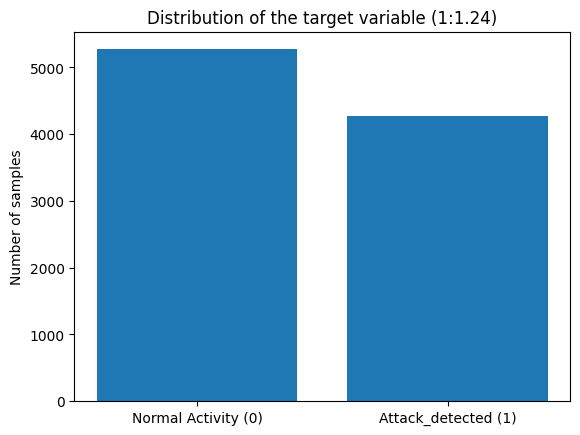

In [ ]:
class_counts = df['attack_detected'].value_counts()
print("Class distribution:\n", class_counts)

minority = class_counts.min()
majority = class_counts.max()
ratio = majority / minority
print(f"Imbalance ratio ≈ 1:{ratio:.2f}")

plt.bar(['Normal Activity (0)', 'Attack_detected (1)'], class_counts)
plt.title(f"Distribution of the target variable (1:{ratio:.2f})")
plt.ylabel("Number of samples")
plt.show()

### Numerical features

**Correlation matrix**

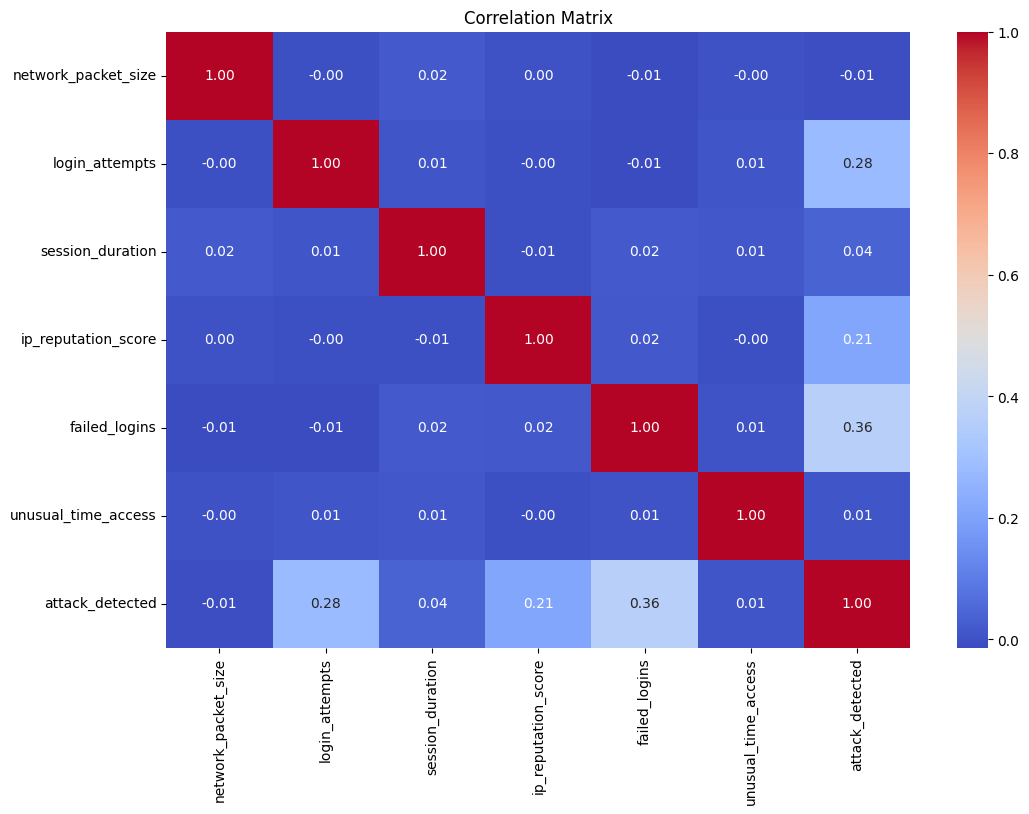

In [ ]:
# Sélection des colonnes numériques
numeric_cols = df.select_dtypes(include=np.number)

# Matrice de corrélation
plt.figure(figsize=(12,8))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The correlation matrix highlights that the variables failed_logins (0.36), login_attempts (0.28) and ip_reputation_score (0.21) are those with the strongest links to the target variable attack_detected. This suggests that a significant number of failed logins or login attempts increases the probability of an attack being detected. Inversely, variables such as network_packet_size, session_duration, and unusual_time_access show correlations close to zero, indicating no significant linear relationship with attack detection.

In this analysis, we tested several resampling techniques. However, the data is nearly balanced (imbalance ratio = 1:1.24), and resampling did not improve model performance. Therefore, we decided not to apply resampling in the upcoming models.

## 3. Formalization of the problem

The goal of this project is to develop a supervised model capable of detecting cybersecurity intrusion based on network traffic and user behavior

This task is a binary classification problem : the model must predict whether a given network session corresponds to a normal activity (0) or an attack (1).

The input features are : network_packet_size, protocol_type, encryption_used, login_attemps, session_duration, failed_logins, browser_type, unusual_time_access, ip_reputation_score

The output variable is attack_detected which is a binary variable that indicates if the session corresponds to an intrusion (1) or a normal activity (0).

As a baseline model, we will implement a Decision Tree Classifier. We chose this algorithm because it is easy to interpret and quick to train and it can handle both categorical and numerical data.

The baseline model will help us to have a reference performance, which will then enable us to measure the improvements achieved through the application of more advanced models or techniques